In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%capture
!pip3 install torchkeras

In [ ]:
%%capture
!pip3 install accelerate

In [ ]:
%%capture
!pip3 install torch==2.2.0

In [ ]:
%%capture
!pip3 install ultralytics

# SSD (Single Shot MultiBox Detector) Model Overview

The SSD (Single Shot MultiBox Detector) model is a popular framework for object detection that allows the detection of multiple objects within an image in a single forward pass of the network. This makes SSD not only efficient but also powerful in terms of speed and accuracy compared to its predecessors. The SSD model architecture is designed to be end-to-end trainable and can handle objects of various sizes, thanks to its multiscale feature map approach for detection.

### Key Features of SSD:

- **Single Shot:** Unlike two-stage detectors (e.g., R-CNN series), SSD performs object localization and classification in a single shot, i.e., one forward pass through the network. This design choice significantly reduces the model's complexity and increases its speed.

- **MultiBox:** The SSD uses a set of default bounding boxes (a.k.a. anchors) of various aspects ratios and scales per feature map location. During training, these default boxes are matched to the ground truth boxes using the Jaccard overlap (a.k.a. Intersection over Union - IoU). The model learns to adjust these default boxes to match the actual object locations and classify the object within the box.

- **Multiscale Feature Maps for Detection:** SSD predicts objects over multiple feature maps with different resolutions to handle objects of various sizes. Lower-level feature maps with higher resolution are used to detect small objects, while higher-level feature maps with lower resolution are used to detect larger objects.

- **Data Augmentation:** To improve the performance and robustness of the model, SSD employs a series of data augmentation techniques such as random crops, flips, and color distortion.

### Model Architecture:

The SSD model typically starts with a base convolutional network (e.g., VGG16, ResNet) pre-trained on a large-scale image classification dataset (e.g., ImageNet). This base network is followed by several convolutional layers with decreasing sizes. Each of these additional layers, along with selected layers from the base network, is used to predict the presence of objects at their respective scale.

### Loss Function:

The SSD model uses a loss function that combines both:

1. **Localization Loss:** A Smooth L1 loss between the predicted box (after adjustments from the default boxes) and the ground truth box coordinates.
2. **Classification Loss:** A Softmax loss over multiple classes predictions.

The total loss is a weighted sum of the localization loss and the classification loss.

### Training and Inference:

During training, SSD adjusts the positions of default bounding boxes to best match the ground truth boxes and learns to classify the objects within these adjusted boxes. During inference, SSD predicts both the bounding box offsets and the class probabilities for each default box, followed by a non-maximum suppression step to produce the final detections.

By combining efficiency and effectiveness, SSD provides a powerful solution for real-time object detection tasks across a wide range of applications.

In [ ]:
# Import necessary libraries
import cv2  # OpenCV library for computer vision tasks
import numpy as np  # NumPy library for numerical computations
import matplotlib.pyplot as plt  # Matplotlib's pyplot for plotting graphs
import os  # OS library for interacting with the operating system
import pandas as pd  # Pandas library for data manipulation and analysis
from PIL import Image, ImageColor, ImageDraw, ImageFont  # PIL for image processing tasks
import torch  # PyTorch library for tensor computations and neural networks
from torch import nn  # nn module from PyTorch for building neural networks
import torchvision  # torchvision for dealing with image data for PyTorch
from torchvision import datasets, models, transforms  # Submodules for datasets, pre-trained models, and image transformations
from torchkeras.plots import vis_detection  # torchkeras for visualizing detections (assuming this is a custom or third-party utility)
import datetime  # datetime library for dealing with dates and times
import copy  # copy library for shallow and deep copying operations
import json  # json library for JSON encoding and decoding
import pickle  # pickle library for serializing and deserializing Python object structures
from PIL import Image  # PIL's Image module for image processing (re-imported for emphasis)
from tqdm import tqdm  # tqdm for displaying progress bars in loops
from ultralytics.utils import set_logging  # Utility from ultralytics for configuring logging (assuming third-party)
set_logging(verbose=False)  # Configure logging to be less verbose
from ultralytics.utils.metrics import DetMetrics, box_iou  # Metrics utilities from ultralytics for object detection evaluation
from torchkeras import KerasModel
import random
from torchvision import transforms as T

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# 0. Data Preprocess
This part processes raw video data for object detection tasks by extracting frames and saving them as individual images. It divides the videos into training and validation sets, ensuring a split that helps in evaluating model performance accurately without data leakage. For both training and validation datasets, every 20th frame from each video is captured and saved as a PNG image, allowing for a manageable dataset size and focusing on key frames that potentially reduce redundancy. This preprocessing step is crucial for transforming video data into a format suitable for training deep learning models for object detection.

- See script: Data_preprocess.py
- video_dir: original path of the training video
- train_dir/val_dir: output path for downsampled frame PNG



In [ ]:
# Define directories for training and validation datasets, and the directory containing raw videos.
train_dir='./drive/MyDrive/Deep Learning/Assignment2/HZ/data/train/'
val_dir='./drive/MyDrive/Deep Learning/Assignment2/HZ/data/val/'
video_dir='./drive/MyDrive/Deep Learning/Assignment2/aicity2024_track5_train/aicity2024_track5_train/videos/'

# List all video files in the raw video directory.
video_files = os.listdir(video_dir)

# Split video files into training and validation sets (80% training, 20% validation).
train_videos = video_files[:int(len(video_files)*0.8)]
val_videos = video_files[int(len(video_files)*0.8):]

In [ ]:
%%capture
# Process training videos.
for f in train_videos:
    output_dir = train_dir  # Specify output directory for training frames.
    cap = cv2.VideoCapture(video_dir+f)  # Open video file.
    frame_count = 0  # Initialize frame count.
    ret = True  # Initialize flag to check if video is still being read.
    while ret:
        ret, frame = cap.read()  # Read frame from video.
        if frame_count % 20 != 0:  # Skip frames to extract every 20th frame.
            frame_count += 1
            continue
        if frame is None:  # Break loop if no frame is returned (end of video).
            break
        output_filename = output_dir + f[:3] + f"_{frame_count}.png"  # Define output filename.
        cv2.imwrite(output_filename, frame)  # Save frame as PNG image.
        frame_count += 1

    cap.release()  # Release video file

In [ ]:
%%capture
# Repeat the process for validation videos.
for f in val_videos:
    output_dir = val_dir  # Specify output directory for validation frames.
    cap = cv2.VideoCapture(video_dir+f)  # Open video file.
    frame_count = 0  # Initialize frame count.
    ret = True  # Initialize flag to check if video is still being read.
    while ret:
        ret, frame = cap.read()  # Read frame from video.
        if frame_count % 20 != 0:  # Skip frames to extract every 20th frame.
            frame_count += 1
            continue
        if frame is None:  # Break loop if no frame is returned (end of video).
            break
        output_filename = output_dir + f[:3] + f"_{frame_count}.png"  # Define output filename.
        cv2.imwrite(output_filename, frame)  # Save frame as PNG image.
        frame_count += 1

    cap.release()  # Release video file.

# 1. Data Loader

In [ ]:
# Paths to directories containing training and validation image datasets.
train_images_path = './drive/MyDrive/Deep Learning/Assignment2/HZ/data/train/'
val_images_path = './drive/MyDrive/Deep Learning/Assignment2/HZ/data/val/'

# Paths to files containing bounding box annotations and class labels for training and validation dataset
# This implies the ground truth data needs to be split according to the train/val split of the images.
train_targets_path = './drive/MyDrive/Deep Learning/Assignment2/aicity2024_track5_train/aicity2024_track5_train/gt.txt'
val_targets_path = './drive/MyDrive/Deep Learning/Assignment2/aicity2024_track5_train/aicity2024_track5_train/gt.txt'

# Define the class names for the object detection task. The '__background__' class is often used to denote
# the absence of objects of interest and is a common practice in object detection tasks to facilitate model training.
class_names = ['__background__', 'Motorbike', 'RiderHelmet', 'RiderNoHelmet']


## 1.1 Dataset Class

We define the `Mydataset` class, which is derived from `torch.utils.data.Dataset`. This class is specifically designed for handling the dataset provided for the object detection task. Here's an overview of its functionality:

- **Initialization**: Upon instantiation, the class loads the list of image files from the specified directory and reads the ground truth annotations from a `.txt` file. The annotations include bounding box information and class labels for objects in each image.

- **Class Mapping**: The original dataset contains 9 object classes, which are consolidated into 3 classes (plus a background class) to simplify the problem. This mapping reduces the complexity of the model and potentially improves its performance on the task.

- **Data Retrieval**: The `__getitem__` method, given an index, loads the corresponding image and retrieves its bounding box labels from the ground truth annotations. It returns a transformed image (as a tensor) and a target dictionary containing the labels, bounding box coordinates, area, and crowd indicators.

- **Length**: The `__len__` method returns the total number of images in the dataset, allowing PyTorch's DataLoader to iterate over the dataset properly.

This setup facilitates the loading and preprocessing of data, making it ready for training and evaluating object detection models.


In [ ]:
# Custom dataset class inheriting from PyTorch's Dataset class.
class Mydataset(torch.utils.data.Dataset):
    # Initialization method for the dataset.
    def __init__(self, images_path, targets_path, class_names=class_names, transforms=None):
        self.images_path = images_path  # Path to the directory containing images.
        self.targets_path = targets_path  # Path to the file containing annotations.
        self.transforms = transforms  # Transformations to be applied on images.
        self.file_list = os.listdir(images_path)  # List of image filenames in the directory.

        # Read the ground truth annotations file and rename the columns for clarity.
        self.all_gt = pd.read_csv(targets_path, sep=',', header=None, names=['id', 'frame', 'tl_x', 'tl_y', 'w', 'h', 'class'])

        # Function to map original class IDs to the simplified 3-class system.
        def f(x):
            if x in (2, 4, 6, 8):
                return 2
            elif x in (3, 5, 7, 9):
                return 3
            return 1

        # Apply the mapping function to the class column.
        self.all_gt['class'] = self.all_gt['class'].apply(lambda x: f(x))
        # Set a multi-level index based on video ID and frame number for easier retrieval.
        self.all_gt = self.all_gt.set_index(['id', 'frame'])
        self.class_names = class_names  # Class names for the dataset.

    # Method to retrieve an item and its annotations by index.
    def __getitem__(self, idx):
        img_name = self.file_list[idx]  # Get filename based on index.
        img_id = int(img_name[:3])  # Extract video ID from filename.
        frame_id = int(img_name[4:-4]) + 1  # Extract frame number from filename.
        img = Image.open(os.path.join(self.images_path, img_name)).convert("RGB")  # Load image and convert to RGB.

        target = {}  # Initialize target dictionary to hold annotations.
        # Retrieve annotations for the current image based on video ID and frame number.
        data = self.all_gt.loc[(img_id, frame_id)]
        # Populate target dictionary with annotations.
        target["image_id"] = torch.tensor([img_id], dtype=torch.int64)
        target["labels"] = torch.tensor(data['class'].values, dtype=torch.int64)
        #target["boxes"] = torch.tensor([[d[0], d[1], d[0] + d[2], d[1] + d[3]] for d in data.values])
        target["area"] = (target["boxes"][:, 3] - target["boxes"][:, 1]) * (target["boxes"][:, 2] - target["boxes"][:, 0])
        target["iscrowd"] = torch.zeros((data.values.shape[0],), dtype=torch.int64)

        # Apply transformations to the image and target if specified.
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target  # Return the processed image and annotations.

    # Method to get the total number of items in the dataset.
    def __len__(self):
        return len(self.file_list)

In [ ]:
%%capture
# Initialize the dataset object for training data.
M = Mydataset(train_images_path, train_targets_path)
# Iterate over all images in the dataset.
for i in range(len(M)):
  try:
    # Attempt to load the image and its corresponding target annotations.
    img, target = M[i]
  except:
    # If an error occurs (e.g., file not found or corrupt), print the index of the problematic file.
    print(i)
    # Remove the problematic file from the dataset to prevent future errors.
    os.remove(train_images_path + M.file_list[i])

In [ ]:
%%capture
# Repeat the process for the validation dataset.
M=Mydataset(val_images_path,val_targets_path)
for i in range(len(M)):
  try:
    img,target = M[i]
  except:
    print(i)
    os.remove(val_images_path+M.file_list[i])

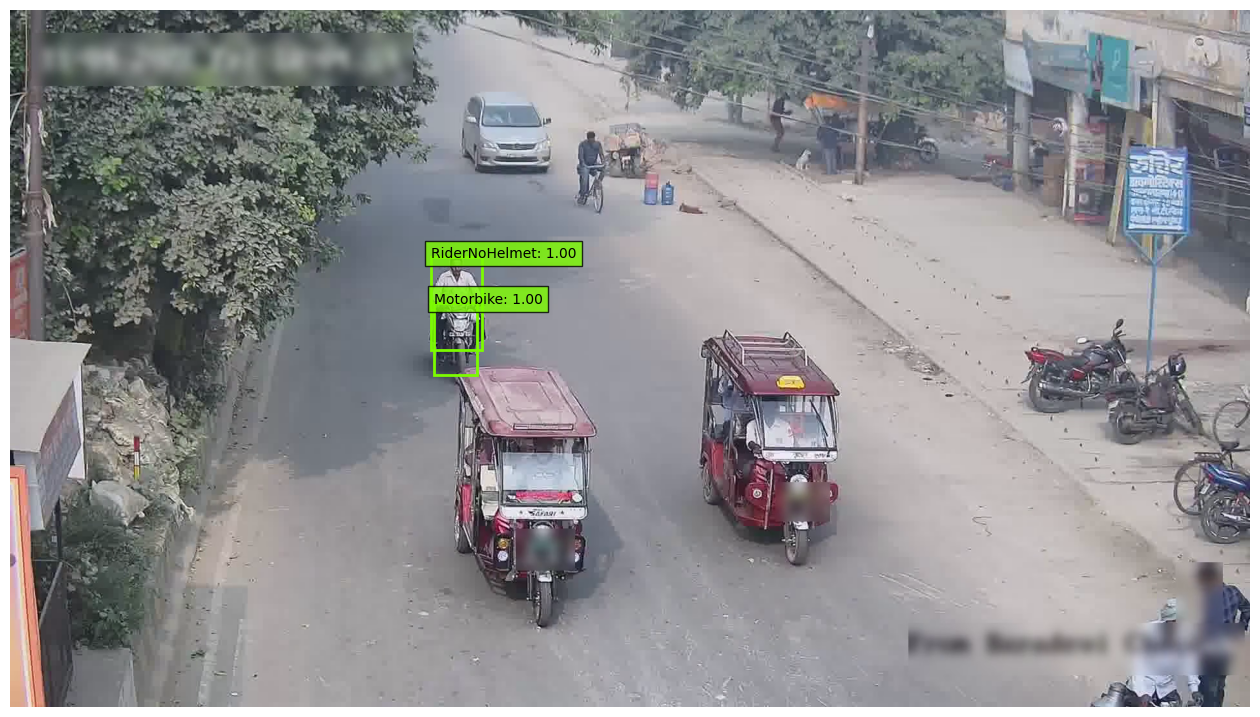

In [ ]:
# Load a specific image and its targets from the validation dataset.
# You can change the index of the loaded image here
img, target = M[110]

# Manually assign a score of 1 to all detections for visualization purposes.
target["scores"] = torch.ones_like(target["labels"])

# Visualize the detections with a minimum score threshold of 0.8.
img_result = vis_detection(img, target, class_names, min_score=0.8)

# Display the resulting image with detected objects.
img_result

## 1.2 Data Augmentation
Data augmentation is a crucial step in preparing our dataset for training. By applying transformations that alter the images and their corresponding annotations in various ways, we can effectively increase the diversity of our training data. This helps improve the robustness and generalization of the model. In this setup, we implement the following data augmentation techniques:

- **Random Horizontal Flip:** With a probability of 0.5, each image in the dataset may be flipped horizontally. This transformation is applied to both the image and its bounding box annotations to maintain consistency. If present, segmentation masks are also flipped. This augmentation helps the model learn invariant features with respect to horizontal flipping, which is common in natural images.

- **ToTensor Transformation:** All images, after potential augmentation, are converted to PyTorch tensors. This is a necessary step for the images to be processed by the neural network models in PyTorch.

We organize these transformations using the `Compose` class, which applies them sequentially. The augmented dataset is then loaded using PyTorch's `DataLoader`, ensuring that batches of data are correctly prepared for training and validation. The `collate_fn` function is defined to properly handle the custom batch collation, accommodating the variable sizes of bounding box annotations.

By leveraging these data augmentation techniques, we aim to enhance the model's learning efficiency and its ability to generalize across unseen data during the inference phase.


In [ ]:
# Compose class to apply multiple transformations sequentially.
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms  # A list of transformations to apply.

    def __call__(self, image, target):
        # Apply each transformation in the list to the image and target.
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

# Class to randomly flip images horizontally.
class RandomHorizontalFlip(object):
    def __init__(self, prob):
        self.prob = prob  # Probability of flipping the image.

    def __call__(self, image, target):
        # Flip the image with the specified probability.
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)  # Horizontally flip the image.
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]  # Adjust the bounding boxes accordingly.
            target["boxes"] = bbox
            # If masks are present, flip them too.
            if "masks" in target:
                target["masks"] = target["masks"].flip(-1)
        return image, target

# Transformation to convert images to PyTorch tensors.
class ToTensor(object):
    def __call__(self, image, target):
        image = T.ToTensor()(image)  # Convert image to tensor.
        return image, target

# Define transformations for training and validation datasets.
transforms_train = Compose([ToTensor(), RandomHorizontalFlip(0.5)])
transforms_val = ToTensor()

# Initialize dataset objects with the defined transformations.
ds_train = Mydataset(train_images_path, train_targets_path, transforms=transforms_train)
ds_val = Mydataset(val_images_path, val_targets_path, transforms=transforms_val)

In [ ]:
# Function to collate data into batches.
def collate_fn(batch):
      return tuple(zip(*batch))

# Initialize data loaders for training and validation datasets.
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=2,
          shuffle=True, num_workers=2,collate_fn= collate_fn)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=2,
          shuffle=True, num_workers=2,collate_fn= collate_fn)

In [ ]:
#len(dl_train)
#len(dl_val)

In [ ]:
# Example of loading a batch from the training data loader.
for batch in dl_train:
    features,labels = batch
    break
labels

({'image_id': tensor([56]),
  'labels': tensor([3, 1, 1, 3, 2, 1, 1, 2, 2]),
  'boxes': tensor([[1041,  385, 1127,  517],
          [1053,  461, 1112,  545],
          [ 719,  681,  823,  856],
          [ 721,  586,  830,  786],
          [ 677,  364,  765,  528],
          [ 683,  442,  757,  565],
          [ 724,  307,  781,  387],
          [ 724,  253,  796,  374],
          [ 984,  201, 1041,  292]]),
  'area': tensor([11352,  4956, 18200, 21800, 14432,  9102,  4560,  8712,  5187]),
  'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0])},)

# 2. Load SSD Model


## 2.1 Model Customization

In this section, we adapt a pre-trained Single Shot MultiBox Detector (SSD) model, initially designed for a broad range of object categories, to a specific task with a custom number of object classes. Our objective is to detect objects belonging to three distinct classes, in addition to a background class, making a total of four classes.

### Loading the Pre-trained Model:
We begin by loading a pre-trained SSD model based on the SSD300 configuration, which utilizes VGG16 as the backbone. This model is well-suited for real-time detection tasks due to its balance between speed and accuracy.

### Custom Model Head:
To tailor the model to our specific needs, we define a new `NewSSDHead` class, replacing the model's original head. This custom head includes:
- **Classification Heads:** Convolutional layers that predict the class of the objects detected in each default bounding box across multiple feature maps.
- **Regression Heads:** Convolutional layers that predict adjustments to the default bounding boxes to better fit the actual objects.

### Feature Map Processing:
For each feature map, we apply the classification and regression heads, reshaping their outputs to facilitate concatenation. This process allows the model to make predictions at multiple scales, enhancing its ability to detect objects of varying sizes.

### Output:
The model's output comprises two key components:
- **Bounding Box Regression (`bbox_regression`):** Adjustments to the positions of the default bounding boxes.
- **Class Logits (`cls_logits`):** Class predictions for each bounding box.

By customizing the SSD model in this manner, we can leverage its powerful detection capabilities for our targeted object detection task.


In [ ]:
# Load a pre-trained SSD300 model using VGG16 as the backbone with default weights
model = torchvision.models.detection.ssd300_vgg16(pretrained=True)

# Define the number of classes (including background) for our specific task
num_classes = 4  # 1 background + 3 actual classes

# Specify the number of anchors for each feature map in the SSD300 model
num_anchors = [4, 6, 6, 6, 4, 4]

# Define the number of output channels for each feature map generated by the SSD300 model
out_channels = [512, 1024, 512, 256, 256, 256]

# Customize the SSD model by defining a new head for classification and regression tasks
class NewSSDHead(nn.Module):
    def __init__(self, num_classes, out_channels, num_anchors):
        super(NewSSDHead, self).__init__()
        # Create a list of convolutional layers for classification, one for each feature map
        self.classification_heads = nn.ModuleList([
            nn.Conv2d(out_channels[i], num_anchors[i] * num_classes, kernel_size=3, padding=1)
            for i in range(len(out_channels))
        ])
        # Create a list of convolutional layers for bounding box regression, one for each feature map
        self.regression_heads = nn.ModuleList([
            nn.Conv2d(out_channels[i], num_anchors[i] * 4, kernel_size=3, padding=1)
            for i in range(len(out_channels))
        ])

    def forward(self, feature_maps):
        # Process each feature map to generate class logits and bounding box regressions
        cls_logits_list = [cls_head(fm) for cls_head, fm in zip(self.classification_heads, feature_maps)]
        bbox_regressions_list = [reg_head(fm) for reg_head, fm in zip(self.regression_heads, feature_maps)]

        # Reshape and concatenate the outputs from all feature maps
        cls_logits = torch.cat([logit.permute(0, 2, 3, 1).contiguous().view(logit.size(0), -1, num_classes) for logit in cls_logits_list], dim=1)
        bbox_regressions = torch.cat([regression.permute(0, 2, 3, 1).contiguous().view(regression.size(0), -1, 4) for regression in bbox_regressions_list], dim=1)

        # Return a dictionary containing the concatenated class logits and bounding box regressions
        return {"bbox_regression": bbox_regressions, "cls_logits": cls_logits}

# Replace the original SSD model head with the customized head
model.head = NewSSDHead(num_classes, out_channels, num_anchors)

## 2.2 Step Runner Customization

In this implementation, we define a `StepRunner` class to handle both training and evaluation steps within our model's training loop. This versatile class allows us to encapsulate the logic needed to process a single batch of data, making it easier to manage both forward and backward passes, along with metrics tracking.

### Key Components:

- **Initialization**: Upon instantiation, the `StepRunner` sets up the necessary components, including the model, loss function, optimizer, and learning rate scheduler. It also determines the training stage and appropriately sets the model to either training or evaluation mode.

- **Batch Processing (`__call__` method)**: The core functionality is provided by the `__call__` method, which processes a single batch of data. It performs a forward pass to compute the loss and, if in training mode, a backward pass followed by a parameter update step.

- **Loss and Metrics Handling**: The total loss is calculated and gathered across all processes to ensure consistency in distributed settings. Additional metrics, such as the learning rate, can be tracked and returned for logging purposes.

This design pattern offers a clean and modular way to structure the training and evaluation steps, facilitating easy modifications and extensions for complex training routines.


In [ ]:
class StepRunner:
    # Initializes the step runner with necessary components for the training or evaluation step
    def __init__(self, net, loss_fn, accelerator, stage="train", metrics_dict=None,
                 optimizer=None, lr_scheduler=None):
        # Assign provided arguments to instance variables
        self.net = net  # The neural network model
        self.loss_fn = loss_fn  # The loss function
        self.metrics_dict = metrics_dict  # Dictionary for additional metrics
        self.stage = stage  # Indicates whether it's a training or evaluation step
        self.optimizer = optimizer  # The optimizer for updating model weights
        self.lr_scheduler = lr_scheduler  # Learning rate scheduler
        self.accelerator = accelerator  # Accelerator for distributed and mixed-precision training

        # Set the model to training mode if in training stage; should be adjusted for evaluation
        if self.stage == 'train':
            self.net.train()
        else:
            self.net.train()

    # Processes a single batch of data
    def __call__(self, batch):
        features, labels = batch  # Unpack the features and labels from the batch

        # Forward pass through the model to get the loss
        loss_dict = self.net(features, labels)
        loss = sum(loss_dict.values())  # Sum up all losses

        # Backward pass and optimizer step if in training mode
        if self.optimizer is not None and self.stage == "train":
            self.accelerator.backward(loss)  # Backward pass with gradient accumulation
            self.optimizer.step()  # Update model parameters
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()  # Adjust learning rate
            self.optimizer.zero_grad()  # Reset gradients

        # Gather loss across all processes
        all_loss = self.accelerator.gather(loss).sum()

        # Record the total loss
        step_losses = {self.stage + "_loss": all_loss.item()}

        # Initialize dictionary for additional metrics
        step_metrics = {}

        # If in training stage, include learning rate in the metrics
        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0

        return step_losses, step_metrics

# Assign this customized StepRunner to the KerasModel class
KerasModel.StepRunner = StepRunner



## 2.3 Training

The training process initiates with capturing the start time for monitoring duration. It utilizes the Adam optimizer with specific learning rate and weight decay parameters to optimize the training of the SSD model. A cosine annealing learning rate scheduler is employed to adjust the learning rate over epochs, aiming to enhance convergence.

### Key Steps:
- **Parameter Selection:** Collects trainable parameters from the model.
- **Optimizer Setup:** Uses Adam for optimization with a fine-tuned learning rate and weight decay.
- **Learning Rate Scheduling:** Adopts a cosine annealing schedule for adjusting the learning rate.
- **Model Training:** Conducts training over 50 epochs with early stopping based on validation loss, saving the best model state.
- **Training Visualization:** Plots and saves training and validation loss curves to monitor performance and overfitting.

### Output:
The process concludes by calculating the total training time, offering insights into efficiency. This streamlined approach focuses on model performance and optimization, concluding with a visual representation of the training journey.

### Visualization:
The saved plot illustrates the training and validation loss trends, serving as a visual aid to assess model learning and convergence behavior over epochs.


<<<<<< ⚡️ cuda is used >>>>>>


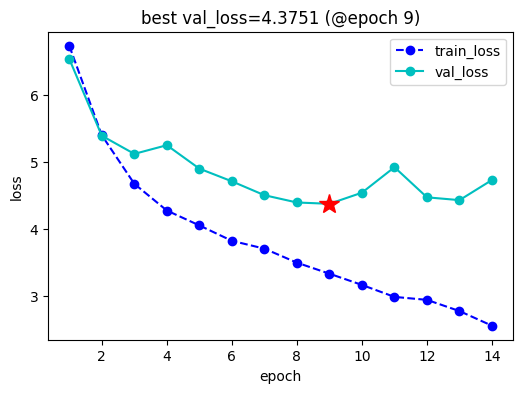

<<<<<< val_loss without improvement in 5 epoch,early stopping >>>>>> 

The code block took 0:07:44.854015 seconds to execute.


In [ ]:
# Record the start time of training
start_time = datetime.datetime.now()

# Collect all trainable parameters from the model
params = [p for p in model.parameters() if p.requires_grad]

# Initialize the optimizer to Adam with specified learning rate and weight decay
optimizer = torch.optim.Adam(params, lr=0.0005, weight_decay=0.0005)
#optimizer = torch.optim.SGD(params, lr=0.0005,momentum=0.9, weight_decay=0.0005)

# Define a learning rate scheduler that adjusts the learning rate using a cosine annealing schedule
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=4)

# Create a KerasModel wrapper for our PyTorch model, specifying the optimizer and learning rate scheduler
keras_model = KerasModel(model, loss_fn=None, metrics_dict=None, optimizer=optimizer, lr_scheduler=lr_scheduler)

# Fit the model to the training data, also validating using the validation data
keras_model.fit(
    train_data=dl_train,
    val_data=dl_val,
    epochs=50,
    patience=5,
    monitor='val_loss',
    mode='min',
    ckpt_path='./drive/MyDrive/Deep Learning/Assignment2/HZ/ssd-model.pt',
    plot=True
)

# Record the end time of training
end_time = datetime.datetime.now()

# Calculate and print the elapsed training time
elapsed_time = end_time - start_time
print(f"The code block took {elapsed_time} seconds to execute.")

In [ ]:
# Define the history of SSD Training
SSD_history = {
    'loss': keras_model.history['train_loss'],  # List of training loss values per epoch
    'val_loss': keras_model.history['val_loss']  # List of validation loss values per epoch
}

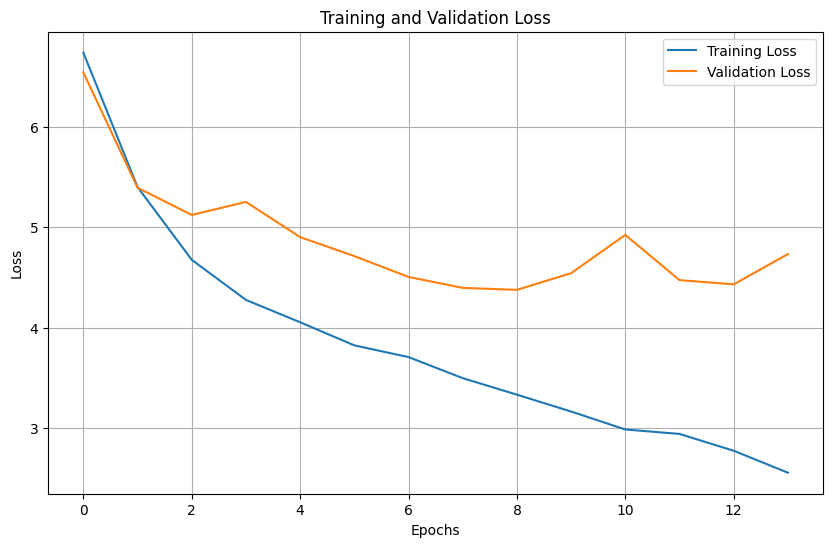

In [ ]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(SSD_history['loss'], label='Training Loss')
plt.plot(SSD_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Save the plot to a file
plt.savefig('./drive/MyDrive/Deep Learning/Assignment2/HZ/SSD_training_history.png')
#plt.close()  # Close the figure to free memory

In [ ]:
# Store the history as .pkl
with open('./drive/MyDrive/Deep Learning/Assignment2/HZ/SSD_history.pkl', 'wb') as file:
    pickle.dump(SSD_history, file)

print("History saved using pickle.")

History saved using pickle.


# 3. Evaluation

This Jupyter notebook segment focuses on evaluating object detection models through a comprehensive set of metrics, including Intersection over Union (IoU), precision, recall, mean Average Precision at IoU=0.5 (mAP50), and mean Average Precision from IoU=0.5 to IoU=0.95 (mAP50-95).

## 3.1 IoU (Intersection over Union)
IoU is a measure of the overlap between two bounding boxes. It is defined as the area of overlap between the predicted bounding box and the ground truth bounding box divided by the area of union of these two boxes. Mathematically, it is expressed as:

$$
\text{IoU} = \frac{\text{Area of Overlap}}{\text{Area of Union}}
$$

## 3.2 Precision and Recall
Precision measures the accuracy of positive predictions, i.e., the fraction of correctly identified objects over the total number of objects identified by the model. Recall measures the ability of the model to find all relevant instances, i.e., the fraction of correctly identified objects over the total number of actual objects. They are defined as:

$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
$$

$$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
$$

## 3.3 mAP (mean Average Precision)
mAP is a popular metric used for evaluating object detection models. mAP50 refers to the mean of the average precision scores at IoU threshold 0.5, and mAP50-95 refers to the mean of the average precision scores calculated at different IoU thresholds from 0.5 to 0.95 (with a step size of 0.05).

## 3.4 Evaluation Process
The evaluation process involves two key functions:

1. **`process_batch`**: This function calculates the correctness of predictions at different IoU levels for a batch of predictions and corresponding ground truth. It returns a matrix indicating whether each prediction is correct across various IoU thresholds.

2. **`eval_metrics`**: This function iterates through lists of predictions and targets, invoking `process_batch` for each pair. It aggregates the correctness, scores, and labels to update and return an object containing detailed evaluation metrics.

These metrics provide insights into the model's performance, aiding in the iterative process of model tuning and improvement.


In [ ]:
# Define a function to process each batch of predictions and targets.
def process_batch(predictions, targets, iouv = torch.linspace(0.5, 0.95, 10)):
    """
    Returns a matrix indicating correct predictions for each IoU threshold.

    Args:
        predictions: A dictionary containing predicted boxes, scores, and labels.
        targets: A dictionary containing ground truth boxes and labels.
        iouv: A tensor of IoU thresholds.

    Returns:
        A tensor indicating correctness of predictions at different IoU levels.
    """

    device = predictions['boxes'].device  # Ensure processing on the same device as the predictions.
    targets = {k:v.to(device) for k,v in targets.items()}  # Move targets to the appropriate device.
    iou = box_iou(targets['boxes'], predictions['boxes'])  # Compute IoU between each prediction and target.

    # Initialize a matrix to track correctness of predictions.
    correct = np.zeros((len(predictions['boxes']), iouv.shape[0])).astype(bool)
    correct_class = (targets['labels'][...,None] == predictions['labels'])  # Check class correctness.

    for i in range(len(iouv)):  # Iterate over each IoU threshold.
        x = torch.where((iou >= iouv[i]) & correct_class)  # Find matches exceeding IoU threshold and class match.
        if x[0].shape[0]:  # If any matches found,
            # Prepare data for deduplication and sorting.
            matches = torch.cat((torch.stack(x, 1), iou[x[0], x[1]][:, None]), 1).cpu().data.numpy()
            if x[0].shape[0] > 1:  # If multiple matches, sort and deduplicate.
                matches = matches[matches[:, 2].argsort()[::-1]]
                matches = matches[np.unique(matches[:, 1], return_index=True)[1]]
                matches = matches[np.unique(matches[:, 0], return_index=True)[1]]
            correct[matches[:, 1].astype(int), i] = True  # Mark as correct for this IoU level.

    return torch.tensor(correct, dtype=torch.bool, device=device)  # Return correctness matrix.

# Define a function to evaluate the metrics for a list of predictions and targets.
def eval_metrics(list_predictions, list_targets, names):
    """
    Evaluates and returns the detection metrics for the provided predictions and targets.

    Args:
        list_predictions: A list of dictionaries containing predictions for each image.
        list_targets: A list of dictionaries containing targets for each image.
        names: Class names for the detections.

    Returns:
        An object containing detailed evaluation metrics.
    """

    metrics = DetMetrics(names=names)  # Initialize metrics object.
    stats = []  # Initialize list to store statistics.

    zips = zip(list_predictions, list_targets)  # Pair each prediction with its corresponding target.
    for predictions, targets in zips:  # For each pair,
        correct = process_batch(predictions, targets)  # Determine correctness of predictions.
        # Aggregate statistics.
        stats.append((correct, predictions['scores'], predictions['labels'], targets['labels'].float()))
    stats = [torch.cat(x, 0).cpu().data.numpy() for x in zip(*stats)]  # Convert aggregated data to NumPy arrays.
    if len(stats) and stats[0].any():  # If there are any correct predictions,
        metrics.process(*stats)  # Update metrics with the aggregated statistics.
    return metrics  # Return the computed metrics.

In [ ]:
#model=model.to('cpu')
model.eval()

cnt=0
list_predictions = []
list_targets=[]
for x in ds_val:
    cnt+=1
    list_predictions.append(model(x[0].to('cpu')[None,...])[0])
list_targets = [x[1] for x in ds_val]

In [ ]:
list_targets[0]

{'image_id': tensor([38]),
 'labels': tensor([1, 3]),
 'boxes': tensor([[ 922,  190, 1021,  297],
         [ 928,  149, 1011,  264]]),
 'area': tensor([10593,  9545]),
 'iscrowd': tensor([0, 0])}

In [ ]:
names = {0:'Motorbike',1:'RiderHelmet',2:'RiderNoHelmet'}
metrics = eval_metrics(list_predictions,list_targets,names = names)

display(metrics.results_dict)

{'metrics/precision(B)': 0.43441606085563383,
 'metrics/recall(B)': 0.4801655614024792,
 'metrics/mAP50(B)': 0.41346024250779884,
 'metrics/mAP50-95(B)': 0.1844923971609923,
 'fitness': 0.20738918169567297}

In [ ]:
import pandas as pd
df = pd.DataFrame()
df['metric'] = metrics.keys
for i,c in names.items():
    df[c] = metrics.class_result(i)
df

,metric,Motorbike,RiderHelmet,RiderNoHelmet
0,metrics/precision(B),0.591950,0.526036,0.185262
1,metrics/recall(B),0.588235,0.604839,0.247423
2,metrics/mAP50(B),0.585492,0.525987,0.128902
3,metrics/mAP50-95(B),0.246742,0.255143,0.051592


# 4. Inference

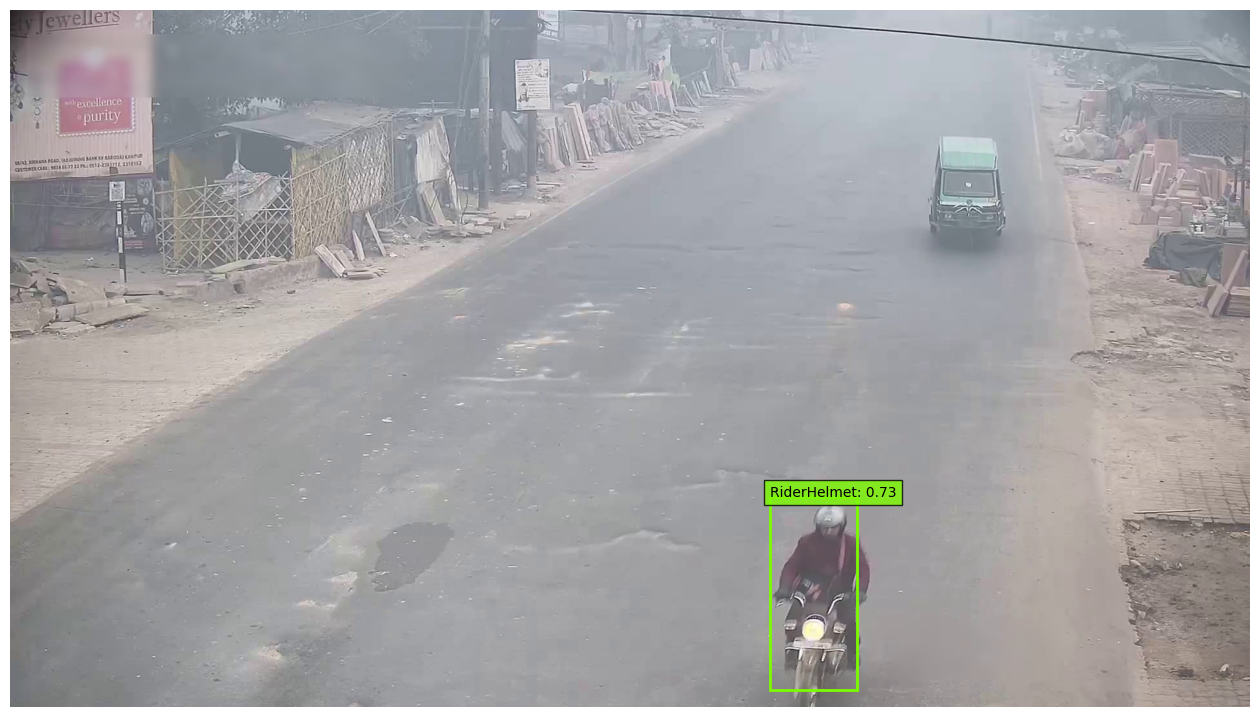

In [ ]:
# Initialize an empty list to store input tensors
inputs = []

# Construct the path to a specific image in the validation dataset
img_path = os.path.join(val_images_path, os.listdir(val_images_path)[55])

# Open the image, convert it to RGB, and then convert to a tensor
img = Image.open(img_path).convert("RGB")
img_tensor = torch.from_numpy(np.array(img)/255.).permute(2,0,1).float()
inputs.append(img_tensor)

# Switch the model to evaluation mode
model.eval()

# Perform prediction while not tracking gradients for efficiency
with torch.no_grad():
    predictions = model(inputs)

# Visualize the detections with a minimum score threshold of 0.5
vis_detection(img, predictions[0], class_names, min_score = 0.5)


In [ ]:
# import re
# import glob

# folder_path = '/content/drive/MyDrive/Deep Learning/Assignment2/HZ'
# video_names = [os.path.basename(video_path).split('.')[0] for video_path in glob.glob(os.path.join(video_dir, '*.mp4'))]  # Assuming video files are .mp4

# def delete_matching_files(folder_path, video_names):
#     for video_name in video_names:
#         pattern = re.compile(rf'^{video_name}_frame_\d+\.jpg$')  # Regex to match {video_name}_frame_{saved_count}.jpg
#         for file_name in os.listdir(folder_path):
#             if pattern.match(file_name):
#                 try:
#                     file_path = os.path.join(folder_path, file_name)
#                     os.remove(file_path)
#                     print(f'Deleted: {file_path}')
#                 except Exception as e:
#                     print(f'Error deleting {file_path}: {e}')

# delete_matching_files(folder_path, video_names)
